In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
import pandas as pd

data = pd.read_csv('C:\\work\\Cybernews\\Notebooks\\data\\downloaded\\india-news-headlines.csv')
data = data[data.headline_category!='unknown']

india                                   270958
business.india-business                 107523
entertainment.hindi.bollywood.news       80086
sports.icc-world-cup-2015                40056
business.international-business          36085
tv.news.hindi                            25788
entertainment.english.hollywood.news     24546
tech.tech-news                           18977
sports.football                          18327
home.education                           17827
Name: headline_category, dtype: int64


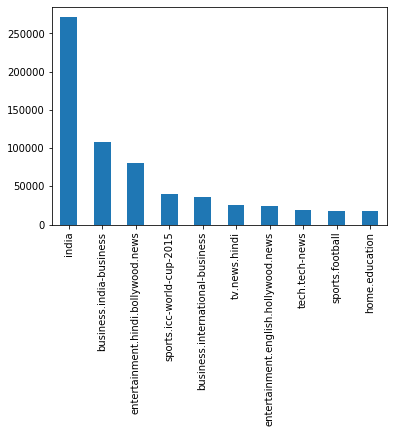

In [3]:
categories = data[data.headline_category.str.contains('city')==False].headline_category.value_counts().sort_values(ascending=False)[0:10]
print(categories)
categories.plot(kind='bar')


In [4]:
categories = ['business.india-business', 'sports.football', 'home.education']

data = data.loc[data['headline_category'].isin(categories)]
data['text_words'] = data.headline_text.str.split()
data['text_len'] = data.text_words.str.len()

In [5]:
samples = data.groupby('headline_category').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)
samples.headline_category.value_counts()

home.education             2000
sports.football            2000
business.india-business    2000
Name: headline_category, dtype: int64

In [6]:
import spacy
nlp_model = "en_core_web_md"
nlp = spacy.load(nlp_model)

In [7]:
import multiprocessing as mp

POS_ALLOWED = ["NOUN", "PROPN"]

docs_lemmatized = []
for doc in nlp.pipe(samples.headline_text.values, n_threads=4):
    doc_lemmatized = []
    doc_ner = []
    for token in doc:
        if(token.pos_ in POS_ALLOWED and token.lemma_ not in doc_lemmatized):
            doc_lemmatized.append(token.lemma_)
    
    docs_lemmatized.append(doc_lemmatized)

df = pd.DataFrame(columns = ['text_lemmatized'])
df["text_lemmatized"] = docs_lemmatized

In [8]:
samples['text_nlp'] = [" ".join(words) for words in df.text_lemmatized.values]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
data_vectorized = vectorizer.fit_transform(samples.text_nlp.values)

In [10]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(samples.headline_category.values)

data_vectorized = data_vectorized.todense()
x_train = data_vectorized[0::2,:]
x_test = data_vectorized[1::4,:]
x_valid = data_vectorized[3::4,:]
y_train = transfomed_label[0::2,:]
y_test = transfomed_label[1::4,:]
y_valid = transfomed_label[3::4,:]

Epoch 00021: early stopping
Train: 0.987, Test: 0.885
 128/1500 [=>............................] - ETA: 640/1500 [===========>..................] - ETA:1408/1500 [===========================>..] - ETA:1500/1500 [==============================] - 0s 79us/step


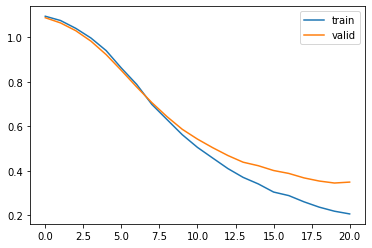

[0.352251185576121, 0.8953333320617676]

In [36]:
from matplotlib import pyplot
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=data_vectorized.shape[1], use_bias=True))
model.add(Dropout(0.5))
model.add(Dense(transfomed_label.shape[1], activation='softmax', use_bias=True))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=50, verbose=0, callbacks=[es])

# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, valid_acc))
# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.legend()
pyplot.show()
score = model.evaluate(x_test, y_test, batch_size=128)
score

In [19]:
score

[0.33709969329833983, 0.8773333322207133]

In [13]:
score = model.evaluate(x_valid, y_valid)

32/1500 [..............................] - ETA: 704/1500 [=============>................] - ETA:1472/1500 [============================>.] - ETA:1500/1500 [==============================] - 0s 73us/step


In [14]:
score

[0.34315683849652606, 0.8746666671435038]